<a href="https://colab.research.google.com/github/efvillar/Ejemplos_GAN/blob/master/1_DCGAN_grayscaleDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo GAN con MNIST



### Carga de librerias

In [ ]:
from matplotlib import pyplot

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

### Carga de Datos

In [ ]:
from keras.datasets.mnist import load_data

### Trasnformación de Datos

In [ ]:
# Se cargan las imágenes en memoria
(trainX, trainy), (testX, testy) = load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#Se verifican las dimensiones de las imágenes
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Son 60.000 imágenes de entrenamiento y 10 de test.   las imagenes tienes 28x28 pixeles y un solo canal.

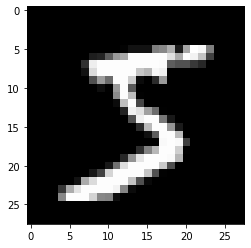

In [ ]:
# muestra de algunas imagenes
pyplot.imshow(trainX[0], cmap='gray')

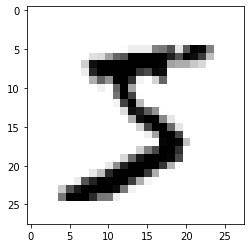

In [ ]:
# muestra de algunas imagenes con color inverso en grayscale
pyplot.imshow(trainX[0], cmap='gray_r')

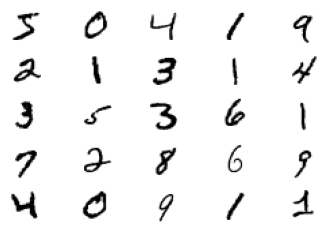

In [ ]:
# Muestra de 25 imágenes
for i in range(25):
    # define subplot and turn off axis
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap="gray_r")
pyplot.show()

### Definición del Modelo Discriminador

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
model = define_discriminator()  #se crea un modelo discriminador

In [ ]:
#visualización del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

### Definición del Modelo Generador

In [ ]:
def define_generator(latent_dim):
    model = Sequential()   #Instancia de Sequential
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7   #arbitrario tamaño de dimensión latente y n_nodes es el tamaño de salida de la primera capa - tiene un tamaño a conveniencia
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation="sigmoid", padding="same"))
    return model

In [ ]:
revisar = define_generator(20)
revisar.summary()  #la salida es 28x28x1 igual que las imágenes reales - y los valores son entre 0 y 1 - igual que las imágenes normalizadas.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              131712    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

### Definición de la función que combina al generador y al discriminador

In [ ]:
def define_gan(g_model, d_model):  #la función toma como inputs una función generadora y una discriminadora
    # make weights in the discriminator not trainable
    d_model.trainable = False   #inicialmente no se entrena el dicriminador
    # connect them
    model = Sequential()        #instancia del Sequential()
    # add generator
    model.add(g_model)          #Se agrega el modelo generador
    # add the discriminator
    model.add(d_model)          #Se agrega el modelos discriminador
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)     #se define el optimizador
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

### Preparación de las imagenes MNIST

In [ ]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype("float32")
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

### Selección de Imagenes reales

In [ ]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

### Generación de puntos aleatorios en el espacio latente

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

### Uso del generador para generar n imagenes fake

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

### Crear y grabar dibujo de imagenes generadas

In [ ]:
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
    # save plot to file
    filename = "generated_plot_e%03d.png" % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

### Evaluar el discriminador, dibujar imagenes generadas y salvar el modelo

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = "generator_model_%03d.h5" % (epoch + 1)
    g_model.save(filename)

### Entrenar el generador y discriminador

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print(">%d, %d/%d, d=%.3f, g=%.3f" % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

### Ejecución del Modelo

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Se han truncado las últimas 5000 líneas del flujo de salida.
>79, 152/234, d=0.690, g=0.715
>79, 153/234, d=0.689, g=0.701
>79, 154/234, d=0.696, g=0.702
>79, 155/234, d=0.696, g=0.721
>79, 156/234, d=0.688, g=0.700
>79, 157/234, d=0.696, g=0.695
>79, 158/234, d=0.689, g=0.685
>79, 159/234, d=0.692, g=0.696
>79, 160/234, d=0.688, g=0.704
>79, 161/234, d=0.693, g=0.694
>79, 162/234, d=0.689, g=0.702
>79, 163/234, d=0.691, g=0.716
>79, 164/234, d=0.693, g=0.707
>79, 165/234, d=0.693, g=0.696
>79, 166/234, d=0.694, g=0.699
>79, 167/234, d=0.691, g=0.689
>79, 168/234, d=0.694, g=0.699
>79, 169/234, d=0.693, g=0.715
>79, 170/234, d=0.693, g=0.711
>79, 171/234, d=0.692, g=0.698
>79, 172/234, d=0.681, g=0.684
>79, 173/234, d=0.691, g=0.690
>79, 174/234, d=0.692, g=0.710
>79, 175/234, d=0.690, g=0.712
>79, 176/234, d=0.689, g=0.690
>79, 177/234, d=0.695, g=0.691
>79, 178/234, d=0.694, g=0.685
>79, 179/234, d=0.688, g=0.694
>79, 180/234, d=0.689, g=0.705
>79, 181/234, d=0.691, g=0.708
>79, 182/